<a href="https://colab.research.google.com/github/Eschamp01/triton-kernels/blob/main/triton_softmax_rowwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Row-wise SoftMax Kernel: Triton vs native PyTorch

In [8]:
!pip install torch -qq

In [2]:
!pip install triton -qq

## Imports

In [3]:
import torch
import triton
import triton.language as tl

## A Naïve SoftMax Implementation in PyTorch

In [4]:
def naive_softmax(x: torch.Tensor)-> torch.Tensor:
    """ eager mode Softmax"""
    x_max = x.max(dim=1)[0]
    safe_x = x - x_max[:, None]
    numerator = torch.exp(safe_x)
    denominator = numerator.sum(dim=1)
    sm_out = numerator/denominator[:,None]
    return sm_out

## A SoftMax Kernel Implementation in Triton

In [5]:
@triton.jit
def _softmax_fwd_kernel(
    output_ptr,
    stride_output_row,
    input_ptr,
    stride_input_row,
    num_cols,
    block_size: tl.constexpr,
):
    # setup input ptrs
    row_index = tl.program_id(0)

    row_start_ptr = input_ptr + (row_index * stride_input_row)
    col_offsets = tl.arange(0,block_size)
    input_pointers = row_start_ptr + col_offsets

    row_mask = col_offsets < num_cols

    # move to SRAM
    row = tl.load(input_pointers,mask = row_mask, other = float("-inf") )

    # softmax itself
    safe_row = row - tl.max(row, axis=0)
    numerator = tl.exp(safe_row)
    denominator = tl.sum(numerator, axis=0)
    sm_out = numerator / denominator

    # write back to HBM
    output_row_ptr = output_ptr + (row_index * stride_output_row)
    output_pointers = output_row_ptr + col_offsets
    tl.store(output_pointers, sm_out, mask= row_mask)

## Using the Triton SoftMax Kernel in PyTorch

In [6]:
def softmax(x:torch.Tensor)->torch.Tensor:
    """ Triton impl of Softmax, fwd pass only """
    rows, cols = x.shape
    assert x.dim() ==2, f"only accepts 2D tensors for now"
    block_size = triton.next_power_of_2(cols)
    num_warps = 4  # *32
    if block_size > 2047: # 2048
        num_warps = 8
    if block_size > 4095: # 4096
        num_warps=16

    grid = (rows,)

    # allocate our output buffer
    sm_out = torch.empty_like(x)

    _softmax_fwd_kernel[grid](
        sm_out,
        sm_out.stride(0),
        x,
        x.stride(0),
        cols,
        block_size=block_size,
        num_warps =num_warps

    )

    return sm_out

## Testing the Performance of the Naïve vs Triton SoftMax Implementations

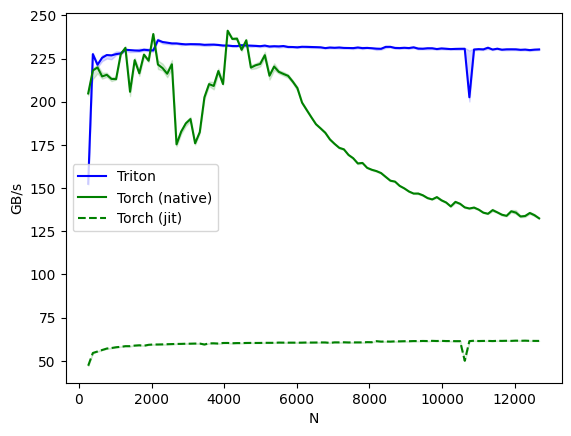

softmax-performance:
          N      Triton  Torch (native)  Torch (jit)
0     256.0  152.497959      204.800005    47.199136
1     384.0  227.555555      218.089851    54.590586
2     512.0  221.405396      219.827254    55.427423
3     640.0  225.442035      214.660992    56.297572
4     768.0  227.030019      215.578943    57.141029
..      ...         ...             ...          ...
93  12160.0  230.057091      133.586243    61.633922
94  12288.0  230.199089      133.854362    61.708470
95  12416.0  229.892673      135.604255    61.591750
96  12544.0  230.136271      134.335110    61.568297
97  12672.0  230.267123      132.508179    61.557605

[98 rows x 4 columns]


<Figure size 640x480 with 0 Axes>

In [7]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[
            128 * i for i in range(2, 100)
        ],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
            'torch-jit',
        ],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch (native)",
            "Torch (jit)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('green', '--')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    )
)
def benchmark(M, N, provider):
    x = torch.randn(M, N, device='cuda', dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: softmax(x), quantiles=quantiles)
    if provider == 'torch-jit':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: naive_softmax(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

from pathlib import Path
benchmark.run(show_plots=True, print_data=True, save_path=Path.cwd())